<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Case-Study:-Northwind-Traders" data-toc-modified-id="Case-Study:-Northwind-Traders-1">Case Study: Northwind Traders</a></span><ul class="toc-item"><li><span><a href="#convert-sql-database-tables-into-pandas-dataframes" data-toc-modified-id="convert-sql-database-tables-into-pandas-dataframes-1.1">convert sql database tables into pandas dataframes</a></span><ul class="toc-item"><li><span><a href="#check-for-normality-in-the-experiment-and-control-samples" data-toc-modified-id="check-for-normality-in-the-experiment-and-control-samples-1.1.1">check for normality in the experiment and control samples</a></span></li></ul></li><li><span><a href="#Question-1:" data-toc-modified-id="Question-1:-1.2">Question 1:</a></span></li><li><span><a href="#Question-2" data-toc-modified-id="Question-2-1.3">Question 2</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Is-there-a-region-that-outperforms-the-others-in-terms-of-order-quantities?" data-toc-modified-id="Is-there-a-region-that-outperforms-the-others-in-terms-of-order-quantities?-1.3.0.1">Is there a region that outperforms the others in terms of order quantities?</a></span></li></ul></li><li><span><a href="#check-for-normality" data-toc-modified-id="check-for-normality-1.3.1">check for normality</a></span><ul class="toc-item"><li><span><a href="#stats-normaltest-confirms-the-distributions-are-not-normalLets-re-sample-to-gather-distribution-means-that-will-satisfy-normality-assumptions" data-toc-modified-id="stats-normaltest-confirms-the-distributions-are-not-normalLets-re-sample-to-gather-distribution-means-that-will-satisfy-normality-assumptions-1.3.1.1">stats normaltest confirms the distributions are not normal<br>Lets re-sample to gather distribution means that will satisfy normality assumptions</a></span></li></ul></li><li><span><a href="#combining-multiple-Series-into-a-DataFrame:-lessons-learned----the-Series-must-have-names-(see-example-above)and-you-must-specify-the-horizontal-axis" data-toc-modified-id="combining-multiple-Series-into-a-DataFrame:-lessons-learned----the-Series-must-have-names-(see-example-above)and-you-must-specify-the-horizontal-axis-1.3.2">combining multiple Series into a DataFrame: <br>lessons learned -- the Series must have names (see example above)<br>and you must specify the horizontal axis</a></span></li><li><span><a href="#need-to-run-ANOVA-here" data-toc-modified-id="need-to-run-ANOVA-here-1.3.3">need to run ANOVA here</a></span></li></ul></li><li><span><a href="#Question-3" data-toc-modified-id="Question-3-1.4">Question 3</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#are-there-any-salespeople-that-stand-out?" data-toc-modified-id="are-there-any-salespeople-that-stand-out?-1.4.0.1">are there any salespeople that stand out?</a></span></li></ul></li></ul></li><li><span><a href="#Question-4" data-toc-modified-id="Question-4-1.5">Question 4</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#are-there-any-categories-we-should-think-about-dicontinuing-or-expanding-on?" data-toc-modified-id="are-there-any-categories-we-should-think-about-dicontinuing-or-expanding-on?-1.5.0.1">are there any categories we should think about dicontinuing or expanding on?</a></span></li></ul></li></ul></li></ul></li></ul></div>

[link to question #2](#link_to_question_#2)
<br>
[link to question #3](#link_to_question_#3) &nbsp;&nbsp;&nbsp; [link to where I need log transformation](#log_transform_here)
<br>
[link to question #4](#link_to_question_#4)




# Case Study: Northwind Traders


Four questions to consider:<br>
1. Do discounted items sell in greater quantites than non-discounted items?  And if so, does the level of discount have an impact?
2. Are there any days per week that stand out?
3. Are the distributions of order Quanitites by time-in-job similar between employees?
4. Does the distribution of product categories purchased change when a discount is offered?


In [1]:
# import packages and modules


import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew
import scipy.stats as stats
from math import sqrt
import math
import copy
import statsmodels.api as sm             #for ANOVA
from statsmodels.formula.api import ols  #for ANOVA
from sklearn import preprocessing

import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import session, sessionmaker
from sqlalchemy import inspect # so we can perform high level investigations

from datetime import timedelta

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use('seaborn')
from matplotlib import style

pd.set_option('display.max_columns', None)

In [2]:
# creating an engine object and a session to connect and work with the Northwind sql db

engine = create_engine("sqlite:///Northwind_small.sqlite", echo = True)
Session = sessionmaker(bind = engine)
session = Session
inspector = inspect(engine)

2019-05-22 00:03:08,435 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-05-22 00:03:08,443 INFO sqlalchemy.engine.base.Engine ()
2019-05-22 00:03:08,445 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-05-22 00:03:08,447 INFO sqlalchemy.engine.base.Engine ()


In [3]:
# lets have a look at the tables we will be working with and get to know them better

inspector.get_table_names()

2019-05-22 00:03:08,459 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-05-22 00:03:08,461 INFO sqlalchemy.engine.base.Engine ()


['Category',
 'Customer',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Employee',
 'EmployeeTerritory',
 'Order',
 'OrderDetail',
 'Product',
 'Region',
 'Shipper',
 'Supplier',
 'Territory']

In [4]:


from sqlalchemy import MetaData
from sqlalchemy.ext.automap import automap_base # creates a framework that clones the db structure so that it can generate a 
                                                  # a new model in which to map the db with its metadata, ie, column headings

In [5]:
# map the db table features with their headings

metadata = MetaData()
metadata.reflect(engine)
Base = automap_base(metadata = metadata)
Base.prepare()

Category, Customer, CustomerCustomerDemo, CustomerDemographic, Employee, EmployeeTerritory, Order, OrderDetail,\
Product, Region, Shipper, Supplier, Territory = \
Base.classes.Category,\
Base.classes.Customer,\
Base.classes.CustomerCustomerDemo,\
Base.classes.CustomerDemographic, \
Base.classes.Employee, \
Base.classes.EmployeeTerritory,\
Base.classes.Order,\
Base.classes.OrderDetail, \
Base.classes.Product, \
Base.classes.Region,\
Base.classes.Shipper, \
Base.classes.Supplier, \
Base.classes.Territory

2019-05-22 00:03:08,511 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-05-22 00:03:08,512 INFO sqlalchemy.engine.base.Engine ()
2019-05-22 00:03:08,516 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Category")
2019-05-22 00:03:08,518 INFO sqlalchemy.engine.base.Engine ()
2019-05-22 00:03:08,524 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'Category' AND type = 'table'
2019-05-22 00:03:08,526 INFO sqlalchemy.engine.base.Engine ()
2019-05-22 00:03:08,528 INFO sqlalchemy.engine.base.Engine PRAGMA foreign_key_list("Category")
2019-05-22 00:03:08,530 INFO sqlalchemy.engine.base.Engine ()
2019-05-22 00:03:08,531 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'Category' AND type = 'table'
2019-05-22 00:03:08,533 INFO sqlalchemy.engine.base.Engin

##### converting each mapped table to a pandas dataframe

In [6]:
# converting each mapped table to a pandas dataframe

category_df= pd.read_sql_query("SELECT * FROM [category]", engine)
customer_df = pd.read_sql_query("SELECT * FROM [customer]", engine)
customerCustomerDemo_df = pd.read_sql_query("SELECT * FROM [customerCustomerDemo]", engine)
customerDemographic_df = pd.read_sql_query("SELECT * FROM [customerDemographic]", engine)
employee_df = pd.read_sql_query("SELECT * FROM [employee]", engine)
employeeTerritory_df = pd.read_sql_query("SELECT * FROM [employeeTerritory]", engine)
order_df = pd.read_sql_query("SELECT * FROM [order]", engine)
orderDetail_df = pd.read_sql_query("SELECT * FROM [orderDetail]", engine)
product_df = pd.read_sql_query("SELECT * FROM [product]", engine)
region_df = pd.read_sql_query("SELECT * FROM [region]", engine)
shipper_df = pd.read_sql_query("SELECT * FROM [shipper]", engine)
supplier_df = pd.read_sql_query("SELECT * FROM [supplier]", engine)
territory_df = pd.read_sql_query("SELECT * FROM [territory]", engine)

2019-05-22 00:03:08,955 INFO sqlalchemy.engine.base.Engine SELECT * FROM [category]
2019-05-22 00:03:08,957 INFO sqlalchemy.engine.base.Engine ()
2019-05-22 00:03:08,965 INFO sqlalchemy.engine.base.Engine SELECT * FROM [customer]
2019-05-22 00:03:08,966 INFO sqlalchemy.engine.base.Engine ()
2019-05-22 00:03:08,983 INFO sqlalchemy.engine.base.Engine SELECT * FROM [customerCustomerDemo]
2019-05-22 00:03:08,984 INFO sqlalchemy.engine.base.Engine ()
2019-05-22 00:03:08,992 INFO sqlalchemy.engine.base.Engine SELECT * FROM [customerDemographic]
2019-05-22 00:03:08,993 INFO sqlalchemy.engine.base.Engine ()
2019-05-22 00:03:08,999 INFO sqlalchemy.engine.base.Engine SELECT * FROM [employee]
2019-05-22 00:03:09,001 INFO sqlalchemy.engine.base.Engine ()
2019-05-22 00:03:09,015 INFO sqlalchemy.engine.base.Engine SELECT * FROM [employeeTerritory]
2019-05-22 00:03:09,016 INFO sqlalchemy.engine.base.Engine ()
2019-05-22 00:03:09,025 INFO sqlalchemy.engine.base.Engine SELECT * FROM [order]
2019-05-22 

In [7]:
employee_df.head(2)

,Id,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address,City,Region,PostalCode,Country,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
0,1,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2024-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp
1,2,Fuller,Andrew,"Vice President, Sales",Dr.,1984-02-19,2024-08-14,908 W. Capital Way,Tacoma,North America,98401,USA,(206) 555-9482,3457,None,Andrew received his BTS commercial in 1974 and...,NaN,http://accweb/emmployees/fuller.bmp


In [8]:
employee_df.HireDate.value_counts()

2025-10-17    2
2026-01-02    1
2026-11-15    1
2024-08-14    1
2024-04-01    1
2024-05-01    1
2025-05-03    1
2026-03-05    1
Name: HireDate, dtype: int64

looks like we have input errors, lets fix those

In [9]:
employee_df.replace({'HireDate':{'2025-10-17':'2005-10-17', '2026-01-02':'2006-01-02', '2024-04-01':'2004-04-01', '2024-08-14':'2004-08-14', '2024-05-01':'2004-05-01',
                                 '2026-03-05':'2006-03-05', '2025-05-03':'2005-05-03', '2026-11-15':'2006-11-15'}}, inplace = True)
employee_df.HireDate.value_counts()

2005-10-17    2
2006-03-05    1
2006-11-15    1
2004-08-14    1
2005-05-03    1
2006-01-02    1
2004-04-01    1
2004-05-01    1
Name: HireDate, dtype: int64

In [10]:
category_df.rename(columns = {"Id":"CategoryId"}, inplace = True)

cat_prod_df = pd.merge(category_df, product_df, how = 'outer', on = "CategoryId" )

cat_prod_df.rename(columns = {"Id": "ProductId"}, inplace = True)

cat_prod_OrDtl_df = pd.merge(cat_prod_df, orderDetail_df, how = 'outer', on = "ProductId")

order_df.rename(columns = {"Id" : "OrderId"}, inplace = True)

cat_prod_OrDtl_orders_df = pd.merge(cat_prod_OrDtl_df, order_df, how = 'outer', on = "OrderId" )

customer_df.rename(columns ={"Id": "CustomerId"}, inplace = True)

cat_prod_OrDtl_orders_cust_df = pd.merge(cat_prod_OrDtl_orders_df, customer_df, how = 'outer', on = "CustomerId")

employee_df.rename(columns = {'Id':'EmployeeId'}, inplace = True)

data = pd.merge(cat_prod_OrDtl_orders_cust_df, employee_df, how = 'outer', on = 'EmployeeId' )

data.head(1)

,CategoryId,CategoryName,Description,ProductId,ProductName,SupplierId,QuantityPerUnit,UnitPrice_x,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued,Id,OrderId,UnitPrice_y,Quantity,Discount,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,CompanyName,ContactName,ContactTitle,Address_x,City_x,Region_x,PostalCode_x,Country_x,Phone,Fax,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address_y,City_y,Region_y,PostalCode_y,Country_y,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
0,1.0,Beverages,"Soft drinks, coffees, teas, beers, and ales",1.0,Chai,1.0,10 boxes x 20 bags,18.0,39.0,0.0,10.0,0.0,10285/1,10285.0,14.4,45.0,0.2,QUICK,1.0,2012-08-20,2012-09-17,2012-08-26,2.0,76.83,QUICK-Stop,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,QUICK-Stop,Horst Kloss,Accounting Manager,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,0372-035188,None,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2004-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp


## <font color='lime'> Question 1 </font>
###### Do discounted items sell in greater quantites than non-discounted items?  And if so, does the level of discount have an impact?

##### Isolate the data we need 

In [11]:
# we will need Quanity and Discount columns to answer both parts of quesiotn 1

q1df = copy.deepcopy(orderDetail_df[["Quantity", "Discount"]])
q1df.head()

,Quantity,Discount
0,12,0.0
1,10,0.0
2,5,0.0
3,9,0.0
4,40,0.0


In [12]:
q1df.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

In [13]:
# remove irrelevant discount levels based on the extremely low number of observations

q1df = copy.deepcopy(q1df[q1df.Discount.isin([ 0.05, 0.10, 0.20, 0.15, 0.25, 0.00])])

In [14]:
# check for null values

q1df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2147 entries, 0 to 2154
Data columns (total 2 columns):
Quantity    2147 non-null int64
Discount    2147 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.3 KB


##### Lets check for normality visually and with statistical tests 

In [15]:
# split the data between the control (no discount) and experiment group (having a discount)

q1_wDis = copy.deepcopy(q1df[q1df.Discount > 0.0])
q1_woDis = copy.deepcopy(q1df[q1df.Discount == 0.0])

print("number observations without discount:", len(q1_woDis))
print("number observations with discount :", len(q1_wDis))

wDisAvg = q1_wDis['Quantity'].mean()
print("avg. quantity sold with discount:" , wDisAvg)

wOdisAvg = q1_woDis['Quantity'].mean()
print("avg. quantity sold without a discount:" , wOdisAvg)

number observations without discount: 1317
number observations with discount : 830
avg. quantity sold with discount: 27.35421686746988
avg. quantity sold without a discount: 21.715261958997722


##### Visual checks for normality 

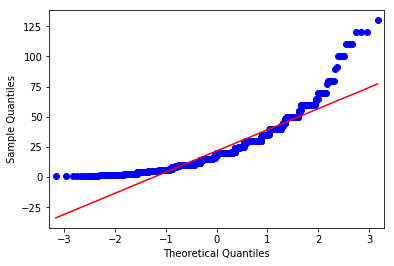

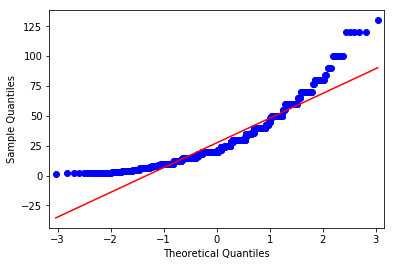

In [16]:
from statsmodels.graphics.gofplots import qqplot

wo_dis = qqplot(q1_woDis.Quantity, line = 's')
w_dis=qqplot(q1_wDis.Quantity, line = 's')

##### The Quanitle Quantile (QQ) plots above for the experiment and control group show a large deviation from the ideal normal distribution (the straight line). 

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


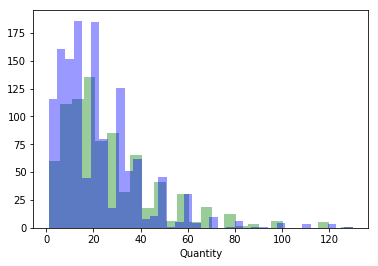

In [17]:
# kde turned off so we see actual frequency instead of normalized frequency

sns.distplot(q1_wDis.Quantity, kde = False, color = 'g', label = "w discount")
sns.distplot(q1_woDis.Quantity, kde = False, color = 'b', label = "wo discount")

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


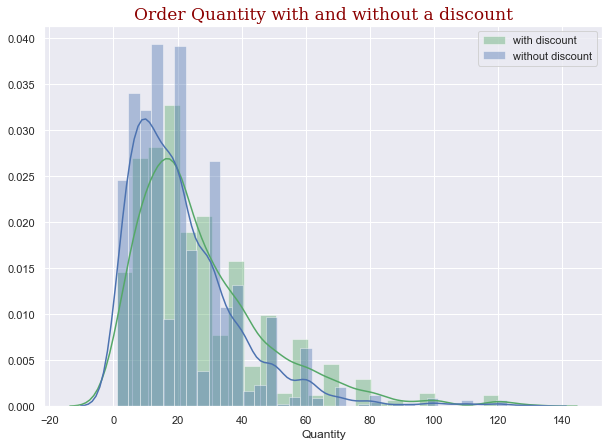

In [18]:
#plt.style.use("dark_background")
#sns.set_color_codes("bright")
sns.set(rc={'figure.figsize':(10,7)})
sns.distplot(q1_wDis.Quantity, color = "g", label = "with discount", norm_hist = False) 
sns.distplot(q1_woDis.Quantity, color = "b", label = "without discount", norm_hist = False) 

font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 17,
        }

plt.title("Order Quantity with and without a discount", fontdict=font)
plt.legend()

###### The qq plots and historgrams look non-normal; lets conifrm with the stats normaltest method which performs a D'Aostino K**2 test that looks at skew (asymetry) and kurtosis (magnitude of observations present in a tail)

In [19]:
print(stats.normaltest(q1_wDis.Quantity))
print(stats.normaltest(q1_woDis.Quantity))

NormaltestResult(statistic=261.04626710761113, pvalue=2.0631145260149106e-57)
NormaltestResult(statistic=544.5770045551502, pvalue=5.579637380545965e-119)


##### P-value for both sets is less than alpha of 0.05 so we reject the null that distribution is normal. <br> Now lets focus on getting our samples to fit a normal distribution<br>we will use the property of the Central Limit Theorem and sampling distribution of the mean

In [20]:
def get_sample(data, n):
    sample = []
    while len(sample) != n:
        x = np.random.choice(data)
        sample.append(x)
    
    return sample

def create_sample_distribution(data, dist_size=2000, n=500):
    sample_dist = []
    while len(sample_dist) != dist_size:
        sample = get_sample(data, n)
        sample_mean = sum(sample) / len(sample)
        sample_dist.append(sample_mean)
    
    return sample_dist




In [21]:
q1_norm_wDis = pd.Series(create_sample_distribution(q1_wDis.Quantity))
q1_norm_woDis = pd.Series(create_sample_distribution(q1_woDis.Quantity))

###### now lets visually inspect the distribution of sample means for the control and experiment groups

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


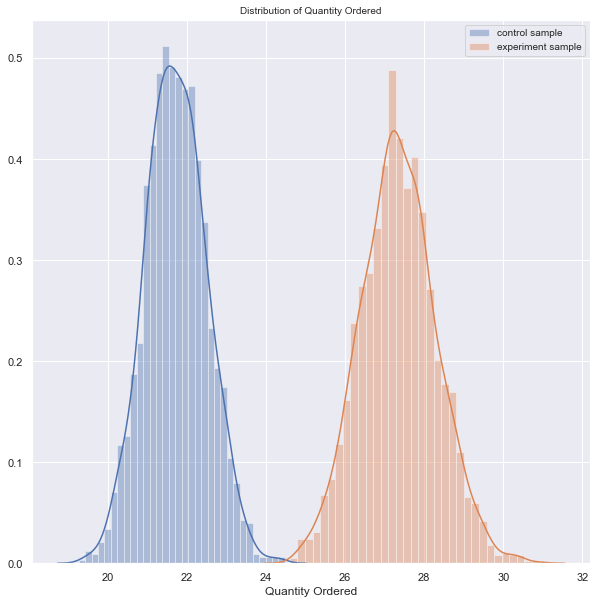

In [22]:
plt.figure(figsize = (10,10))
sns.distplot(q1_norm_woDis, label = "control sample")
sns.distplot(q1_norm_wDis, label = "experiment sample")
plt.title("Distribution of Quantity Ordered", fontsize= 10)
plt.xlabel("Quantity Ordered")
plt.legend(fontsize = 10)

In [23]:
print(stats.normaltest(q1_norm_woDis))
print(stats.normaltest(q1_norm_wDis))

NormaltestResult(statistic=3.0785640513592867, pvalue=0.21453507682114745)
NormaltestResult(statistic=6.605051322157788, pvalue=0.036790130560089195)


##### running a normal test on the new data we see we fail to reject the null that the distributions are normal <br> Our data now satisfies the normality assumption. 

## Question 1: 
##### Does offering a discount precipitate a meaningful difference in order quantity?<br> And if so, is there a discount level that stands out from the rest?

question 1 part a
<br>
$H_O$: Offering a discount does not change the average order quantity<br>
$H_a$: Products having a discount are ordered in greater quantities compared to those not having a discount<br>

this is a one tail test

In [24]:
# Run a T-test

#print(stats.ttest_ind(q1_wDis.Quantity, q1_woDis.Quantity , equal_var = False))

print(stats.ttest_ind(q1_norm_wDis, q1_norm_woDis , equal_var = False))


Ttest_indResult(statistic=205.59087913760692, pvalue=0.0)


In [25]:
print(type(q1_norm_wDis))
q1_norm_wDis.mean()

<class 'pandas.core.series.Series'>


27.342686

In [26]:
print(type(q1_norm_woDis))
q1_norm_woDis.mean()

<class 'pandas.core.series.Series'>


21.71678

In [27]:
print("avg. quantity sold with discount:" , q1_norm_wDis.mean())
print("avg. quantity sold without a discount:" , q1_norm_woDis.mean())
print("difference in avg. quantity sold (simple effect size):", round(q1_norm_wDis.mean() - q1_norm_woDis.mean(),0) )
print("relative to not using a discount, discounted items increase quanties sold by {} percent on avearge" .format(round(((q1_norm_wDis.mean() - q1_norm_woDis.mean())/q1_norm_woDis.mean())*100),1))

#print("Effect size: ", round(discount['Quantity'].mean() - no_discount['Quantity'].mean(),1))
#print("Relative effect size: ", round((discount['Quantity'].mean() - no_discount['Quantity'].mean())/no_discount['Quantity'].mean(),2))

avg. quantity sold with discount: 27.342686
avg. quantity sold without a discount: 21.71678
difference in avg. quantity sold (simple effect size): 6.0
relative to not using a discount, discounted items increase quanties sold by 26.0 percent on avearge


#####  <font color='yellow'> Conclusion part 1a </font>
Our P-value and T-score tell us we can confidently reject the null hypothsis (P value is less than alpha and T score is greater than critical value of 1.96) so we now know that the sample means are different and that we can trust the results of the test to a statistically significant degree.

###### Question 1 part b

for the next part of the question, we will dig a bit deeper to determine if there is a certain level of discount that precipitates an increase in order size, or not

will separate/bin the discount levels so we can compare each experiment group to the control

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


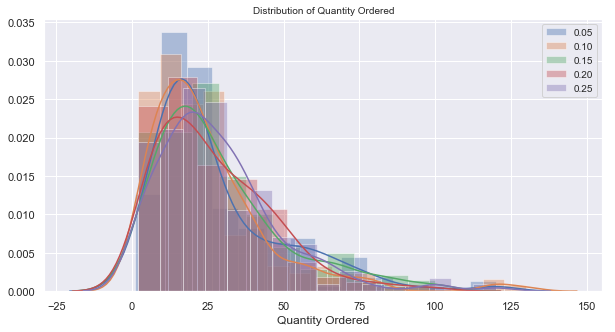

In [28]:


plt.figure(figsize = (10,5))

sns.distplot(q1_wDis['Quantity'][q1_wDis['Discount']==0.05], label = "0.05")
sns.distplot(q1_wDis['Quantity'][q1_wDis['Discount']==0.10], label = "0.10")
sns.distplot(q1_wDis['Quantity'][q1_wDis['Discount']==0.15], label = "0.15")
sns.distplot(q1_wDis['Quantity'][q1_wDis['Discount']==0.20], label = "0.20")
sns.distplot(q1_wDis['Quantity'][q1_wDis['Discount']==0.25], label = "0.25")



plt.title("Distribution of Quantity Ordered", fontsize= 10)
plt.xlabel("Quantity Ordered")
plt.legend(fontsize = 10)

In [29]:
q1a_feature_groups = [ 
                       q1_wDis['Quantity'][q1_wDis['Discount']==.05], 
                       q1_wDis['Quantity'][q1_wDis['Discount']==.10], 
                       q1_wDis['Quantity'][q1_wDis['Discount']==.15], 
                       q1_wDis['Quantity'][q1_wDis['Discount']==.20], 
                       q1_wDis['Quantity'][q1_wDis['Discount']==.25] 
                     ]


for i in q1a_feature_groups:
    print(stats.normaltest(i))

NormaltestResult(statistic=63.84242740591745, pvalue=1.3702286160643066e-14)
NormaltestResult(statistic=98.50271035413209, pvalue=4.0776337983848464e-22)
NormaltestResult(statistic=38.52550343019272, pvalue=4.308173885400061e-09)
NormaltestResult(statistic=31.398997154435623, pvalue=1.519827852850104e-07)
NormaltestResult(statistic=54.44887806745976, pvalue=1.5016763972075847e-12)


groups of the different discount levels are not Gaussian

In [30]:

df_05 = q1df[q1df.Discount == 0.05]
df_10 = q1df[q1df.Discount == 0.10]
df_15 = q1df[q1df.Discount == 0.15]
df_20 = q1df[q1df.Discount == 0.20]
df_25 = q1df[q1df.Discount == 0.25]


norm_05 = create_sample_distribution(df_05.Quantity, dist_size=1000, n=1000)
norm_10 = create_sample_distribution(df_10.Quantity, dist_size=1000, n=1000)
norm_15 = create_sample_distribution(df_15.Quantity, dist_size=1000, n=1000)
norm_20 = create_sample_distribution(df_20.Quantity, dist_size=1000, n=1000)
norm_25 = create_sample_distribution(df_25.Quantity, dist_size=1000, n=1000)

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


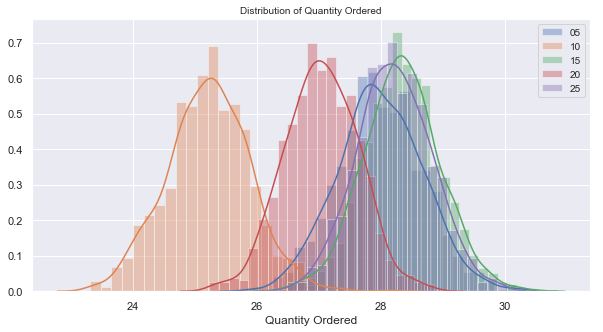

In [31]:
plt.figure(figsize = (10,5))


sns.distplot(norm_05, label = "05")
sns.distplot(norm_10, label = "10")
sns.distplot(norm_15, label = "15")
sns.distplot(norm_20, label = "20")
sns.distplot(norm_25, label = "25")

plt.title("Distribution of Quantity Ordered", fontsize= 10)
plt.xlabel("Quantity Ordered")
plt.legend(fontsize = 10)

In [32]:
norm_levels = [norm_05, norm_10, norm_15, norm_20, norm_25]

for level in norm_levels:
    print(stats.normaltest(level))

NormaltestResult(statistic=1.0620936080678856, pvalue=0.5879891380054725)
NormaltestResult(statistic=4.132617574840539, pvalue=0.12665242095234958)
NormaltestResult(statistic=2.100793449214993, pvalue=0.34979894772977327)
NormaltestResult(statistic=0.18481935135066938, pvalue=0.9117315587827233)
NormaltestResult(statistic=1.0627701339794202, pvalue=0.5877902766972948)


In [33]:
# converting the lists of resampled quantities into series


norm_05=pd.Series( norm_05, name= 'norm_05')
norm_10=pd.Series( norm_10, name= 'norm_10')
norm_15=pd.Series( norm_15, name= 'norm_15')
norm_20=pd.Series( norm_20, name= 'norm_20')
norm_25=pd.Series(norm_25, name= 'norm_25')

# combining the series into a dataFrame
norm_dis_df = pd.DataFrame(pd.concat([norm_05, norm_10, norm_15, norm_20, norm_25], axis = 1))

# using .melt() to change the datas structure into one that will allow me to compute ANOVA
norm_discount_melted_df = copy.deepcopy(pd.melt(norm_dis_df))

# renaming column names to be intuitive
norm_discount_melted_df.rename(columns = {'variable': 'Discount', 'value': 'Quantity'}, inplace=True)

#norm_discount_melted_df.replace({'Discount':{'norm_05':0.05, 'norm_10':0.10, 'norm_15':0.15, 'norm_20':0.20, 'norm_25':0.25}}, inplace = True)
norm_discount_melted_df.head()

,Discount,Quantity
0,norm_05,28.171
1,norm_05,26.856
2,norm_05,27.968
3,norm_05,28.493
4,norm_05,28.783


ANOVA Table

In [34]:
formula = "Quantity ~ C(Discount)"
           
lm = ols(formula, q1_wDis).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)


                    sum_sq     df         F    PR(>F)
C(Discount)    1159.517551    4.0  0.674103  0.610041
Residual     354768.342690  825.0       NaN       NaN


###### The ANOVA F statistic is not in the rejection region, being less than the critical value of 2.57, however, the P-value is insignificant, so we fail to reject the null that the magnitude of impact between the varying discount levels on quantities sold are equal.  

##### <font color='yellow'> Conclusion part 1b </font>

**Restate the question and hypotheses:**<br>
is there a difference in magnitude of impact on order quantities between the varying discount levels?<br>
𝐻𝑂: All discount groups have an equal impact on order quantities<br>
𝐻𝑎: Varying discount levels produce different results on order quantities<br>

There is no significant difference in order quantities between the different disscount levels.
The implication of this conclusion is that Northwind can achieve the same results with a 5% discount as a 25% discount, so, they should use the less expensive discount to buy demand.

<a id='link_to_question_#2'></a>


## <font color ='lime'> Question 2 </font>
###### Are order quantities equivalent by day of the week?

$H_O$: Order quantities are uniform between days of the week <br>
$H_a$: Order quantities vary with significance between days of the week<br>

this is a two tailed test

In [35]:
data.head()

,CategoryId,CategoryName,Description,ProductId,ProductName,SupplierId,QuantityPerUnit,UnitPrice_x,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued,Id,OrderId,UnitPrice_y,Quantity,Discount,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,CompanyName,ContactName,ContactTitle,Address_x,City_x,Region_x,PostalCode_x,Country_x,Phone,Fax,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address_y,City_y,Region_y,PostalCode_y,Country_y,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
0,1.0,Beverages,"Soft drinks, coffees, teas, beers, and ales",1.0,Chai,1.0,10 boxes x 20 bags,18.0,39.0,0.0,10.0,0.0,10285/1,10285.0,14.4,45.0,0.2,QUICK,1.0,2012-08-20,2012-09-17,2012-08-26,2.0,76.83,QUICK-Stop,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,QUICK-Stop,Horst Kloss,Accounting Manager,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,0372-035188,None,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2004-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp
1,6.0,Meat/Poultry,Prepared meats,53.0,Perth Pasties,24.0,48 pieces,32.8,0.0,0.0,0.0,1.0,10285/53,10285.0,26.2,36.0,0.2,QUICK,1.0,2012-08-20,2012-09-17,2012-08-26,2.0,76.83,QUICK-Stop,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,QUICK-Stop,Horst Kloss,Accounting Manager,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,0372-035188,None,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2004-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp
2,8.0,Seafood,Seaweed and fish,40.0,Boston Crab Meat,19.0,24 - 4 oz tins,18.4,123.0,0.0,30.0,0.0,10285/40,10285.0,14.7,40.0,0.2,QUICK,1.0,2012-08-20,2012-09-17,2012-08-26,2.0,76.83,QUICK-Stop,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,QUICK-Stop,Horst Kloss,Accounting Manager,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,0372-035188,None,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2004-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp
3,1.0,Beverages,"Soft drinks, coffees, teas, beers, and ales",2.0,Chang,1.0,24 - 12 oz bottles,19.0,17.0,40.0,25.0,0.0,10991/2,10991.0,19.0,50.0,0.2,QUICK,1.0,2014-04-01,2014-04-29,2014-04-07,1.0,38.51,QUICK-Stop,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,QUICK-Stop,Horst Kloss,Accounting Manager,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,0372-035188,None,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2004-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp
4,1.0,Beverages,"Soft drinks, coffees, teas, beers, and ales",70.0,Outback Lager,7.0,24 - 355 ml bottles,15.0,15.0,10.0,30.0,0.0,10991/70,10991.0,15.0,20.0,0.2,QUICK,1.0,2014-04-01,2014-04-29,2014-04-07,1.0,38.51,QUICK-Stop,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,QUICK-Stop,Horst Kloss,Accounting Manager,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,0372-035188,None,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2004-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp


In [36]:
q2df = copy.deepcopy(data[[ "Quantity", "OrderDate"]])
q2df.head()


,Quantity,OrderDate
0,45.0,2012-08-20
1,36.0,2012-08-20
2,40.0,2012-08-20
3,50.0,2014-04-01
4,20.0,2014-04-01


In [37]:
q2df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2161 entries, 0 to 2160
Data columns (total 2 columns):
Quantity     2155 non-null float64
OrderDate    2155 non-null object
dtypes: float64(1), object(1)
memory usage: 50.6+ KB


In [38]:
# we need to convert the OrderDate column from a string (object) to a DateTime type.

q2df.OrderDate = pd.to_datetime(q2df.OrderDate, infer_datetime_format=True)
q2df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2161 entries, 0 to 2160
Data columns (total 2 columns):
Quantity     2155 non-null float64
OrderDate    2155 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 50.6 KB


In [39]:
q2df['DayOfWeek'] = q2df['OrderDate'].dt.day_name()
q2df.head()

,Quantity,OrderDate,DayOfWeek
0,45.0,2012-08-20,Monday
1,36.0,2012-08-20,Monday
2,40.0,2012-08-20,Monday
3,50.0,2014-04-01,Tuesday
4,20.0,2014-04-01,Tuesday


In [40]:
q2df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2161 entries, 0 to 2160
Data columns (total 3 columns):
Quantity     2155 non-null float64
OrderDate    2155 non-null datetime64[ns]
DayOfWeek    2155 non-null object
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 67.5+ KB


In [92]:
q2df.DayOfWeek.value_counts()

Tuesday      449
Wednesday    436
Thursday     428
Monday       425
Sunday       417
Name: DayOfWeek, dtype: int64

In [41]:
q2df.isnull().sum()

Quantity     6
OrderDate    6
DayOfWeek    6
dtype: int64

In [42]:
q2df.dropna(inplace = True)

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


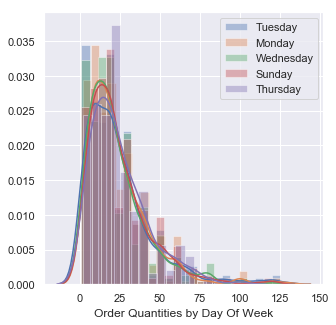

In [91]:
plt.figure(figsize = (5,5))

for day in set(q2df.DayOfWeek):
    helper = q2df.loc[q2df.DayOfWeek == day]
    sns.distplot(helper.Quantity, label = day)
    plt.legend()
    plt.xlabel('Order Quantities by Day Of Week')


In [90]:
for day in set(q2df['DayOfWeek']):
    helper = q2df.loc[q2df.DayOfWeek == day]
    print(stats.normaltest(helper.Quantity))

NormaltestResult(statistic=194.84191471743983, pvalue=4.904737820075197e-43)
NormaltestResult(statistic=196.96658929402193, pvalue=1.695307858430877e-43)
NormaltestResult(statistic=150.1345580089754, pvalue=2.5043496105433636e-33)
NormaltestResult(statistic=161.49882980735737, pvalue=8.530503989495187e-36)
NormaltestResult(statistic=93.14375548848395, pvalue=5.944159902987768e-21)


In [101]:
# distributions are not normal; lets log transform
q2df['log'] = np.log(q2df.Quantity)



In [102]:
q2df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2155 entries, 0 to 2154
Data columns (total 4 columns):
Quantity     2155 non-null float64
OrderDate    2155 non-null datetime64[ns]
DayOfWeek    2155 non-null object
log          2155 non-null float64
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 164.2+ KB


C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


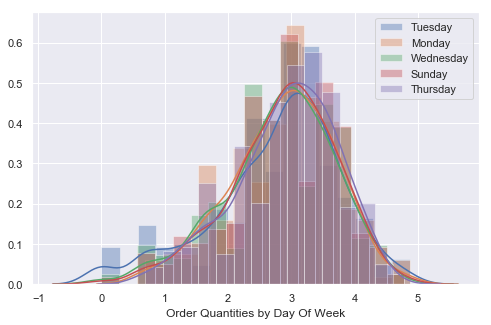

In [107]:
plt.figure(figsize = (8,5))

for day in set(q2df.DayOfWeek):
    helper = q2df.loc[q2df.DayOfWeek == day]
    sns.distplot(helper.log, label = day)
    plt.legend()
    plt.xlabel('Order Quantities by Day Of Week')


In [104]:
for day in set(q2df['DayOfWeek']):
    helper = q2df.loc[q2df.DayOfWeek == day]
    print(stats.normaltest(helper.log))

NormaltestResult(statistic=34.91516866212612, pvalue=2.6197958971551106e-08)
NormaltestResult(statistic=8.609122534538198, pvalue=0.013506810121744138)
NormaltestResult(statistic=22.079294564388913, pvalue=1.6052478731796008e-05)
NormaltestResult(statistic=22.284386532718354, pvalue=1.4487950321080658e-05)
NormaltestResult(statistic=17.965233636635062, pvalue=0.00012557381332319254)


In [105]:
formula = "Quantity ~ C(DayOfWeek)"
           
lm = ols(formula, q2df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                     sum_sq      df         F  PR(>F)
C(DayOfWeek)     662.192111     4.0  0.457058  0.7673
Residual      778737.444084  2150.0       NaN     NaN


##### <font color='yellow'> Conclusion Question 2 </font>

With a P-value greater than alpha of 0.05, we are not able to reject the null hypotheses that order quantities are uniform through days of the week.

<a id='link_to_question_#3'></a>



## <font color ='lime'> Question 3 </font>
Are the distributions of order Quanitites by time-in-job similar between employees?

$H_O$: all sales peoples performance are identical between experience levels <br>
$H_a$: associate performance accross experience levels are not equivalent<br>

this is a two tailed test

In [46]:
q3df = copy.deepcopy(data[['EmployeeId', 'Quantity', ]])

print(q3df.EmployeeId.value_counts())
print(q3df.head())

4.0    420
1.0    345
3.0    321
8.0    260
2.0    241
7.0    176
6.0    168
5.0    117
9.0    107
Name: EmployeeId, dtype: int64
   EmployeeId  Quantity
0         1.0      45.0
1         1.0      36.0
2         1.0      40.0
3         1.0      50.0
4         1.0      20.0


In [47]:
data.head(2)

,CategoryId,CategoryName,Description,ProductId,ProductName,SupplierId,QuantityPerUnit,UnitPrice_x,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued,Id,OrderId,UnitPrice_y,Quantity,Discount,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,CompanyName,ContactName,ContactTitle,Address_x,City_x,Region_x,PostalCode_x,Country_x,Phone,Fax,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address_y,City_y,Region_y,PostalCode_y,Country_y,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
0,1.0,Beverages,"Soft drinks, coffees, teas, beers, and ales",1.0,Chai,1.0,10 boxes x 20 bags,18.0,39.0,0.0,10.0,0.0,10285/1,10285.0,14.4,45.0,0.2,QUICK,1.0,2012-08-20,2012-09-17,2012-08-26,2.0,76.83,QUICK-Stop,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,QUICK-Stop,Horst Kloss,Accounting Manager,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,0372-035188,None,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2004-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp
1,6.0,Meat/Poultry,Prepared meats,53.0,Perth Pasties,24.0,48 pieces,32.8,0.0,0.0,0.0,1.0,10285/53,10285.0,26.2,36.0,0.2,QUICK,1.0,2012-08-20,2012-09-17,2012-08-26,2.0,76.83,QUICK-Stop,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,QUICK-Stop,Horst Kloss,Accounting Manager,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,0372-035188,None,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2004-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp


In [48]:
q3df = copy.deepcopy(data[['Quantity', 'EmployeeId', 'HireDate', 'OrderDate' ]])
q3df.head()


,Quantity,EmployeeId,HireDate,OrderDate
0,45.0,1.0,2004-05-01,2012-08-20
1,36.0,1.0,2004-05-01,2012-08-20
2,40.0,1.0,2004-05-01,2012-08-20
3,50.0,1.0,2004-05-01,2014-04-01
4,20.0,1.0,2004-05-01,2014-04-01


In [49]:
q3df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2161 entries, 0 to 2160
Data columns (total 4 columns):
Quantity      2155 non-null float64
EmployeeId    2155 non-null float64
HireDate      2155 non-null object
OrderDate     2155 non-null object
dtypes: float64(2), object(2)
memory usage: 84.4+ KB


In [50]:
q3df.HireDate = pd.to_datetime(q3df.HireDate, infer_datetime_format=True)
q3df.OrderDate = pd.to_datetime(q3df.OrderDate, infer_datetime_format=True)

In [51]:
q3df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2161 entries, 0 to 2160
Data columns (total 4 columns):
Quantity      2155 non-null float64
EmployeeId    2155 non-null float64
HireDate      2155 non-null datetime64[ns]
OrderDate     2155 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(2)
memory usage: 84.4 KB


In [52]:
#from dateutil import relativedelta
#from dateutil.relativedelta import *
from dateutil.relativedelta import relativedelta

#q3df['TimeInJob'] = (q3df['OrderDate'] - q3df['HireDate'] )
#q3df['yrsInJob'] = relativedelta(q3df['OrderDate'], q3df['HireDate'])

q3df['MonthsInJob'] = round(((q3df.OrderDate - q3df.HireDate)/np.timedelta64(1,'M')),0)



In [53]:
#q3df.drop(['TimeInJob', 'yrsInJob'], axis= 1, inplace = True)
q3df.drop(['HireDate', 'OrderDate'], axis = 1, inplace = True)
q3df.head()

,Quantity,EmployeeId,MonthsInJob
0,45.0,1.0,100.0
1,36.0,1.0,100.0
2,40.0,1.0,100.0
3,50.0,1.0,119.0
4,20.0,1.0,119.0


In [54]:
Quantity_perEmployee_byMonthsInJob = copy.deepcopy(q3df)

In [55]:
# splitting datafram into testible constituent eliments

empl_1 = Quantity_perEmployee_byMonthsInJob[Quantity_perEmployee_byMonthsInJob['EmployeeId']==1]
empl_1.drop(['EmployeeId'], axis = 1, inplace = True)

empl_2 = Quantity_perEmployee_byMonthsInJob[Quantity_perEmployee_byMonthsInJob['EmployeeId']==2]
empl_2.drop(['EmployeeId'], axis = 1, inplace = True)

empl_3 = Quantity_perEmployee_byMonthsInJob[Quantity_perEmployee_byMonthsInJob['EmployeeId']==3]
empl_3.drop(['EmployeeId'], axis = 1, inplace = True)

empl_4 = Quantity_perEmployee_byMonthsInJob[Quantity_perEmployee_byMonthsInJob['EmployeeId']==4]
empl_4.drop(['EmployeeId'], axis = 1, inplace = True)

empl_5 = Quantity_perEmployee_byMonthsInJob[Quantity_perEmployee_byMonthsInJob['EmployeeId']==5]
empl_5.drop(['EmployeeId'], axis = 1, inplace = True)

empl_6 = Quantity_perEmployee_byMonthsInJob[Quantity_perEmployee_byMonthsInJob['EmployeeId']==6]
empl_6.drop(['EmployeeId'], axis = 1, inplace = True)

empl_7 = Quantity_perEmployee_byMonthsInJob[Quantity_perEmployee_byMonthsInJob['EmployeeId']==7]
empl_7.drop(['EmployeeId'], axis = 1, inplace = True)

empl_8 = Quantity_perEmployee_byMonthsInJob[Quantity_perEmployee_byMonthsInJob['EmployeeId']==8]
empl_8.drop(['EmployeeId'], axis = 1, inplace = True)

empl_9 = Quantity_perEmployee_byMonthsInJob[Quantity_perEmployee_byMonthsInJob['EmployeeId']==9]
empl_9.drop(['EmployeeId'], axis = 1, inplace = True)


C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [56]:
empl_1.head()

,Quantity,MonthsInJob
0,45.0,100.0
1,36.0,100.0
2,40.0,100.0
3,50.0,119.0
4,20.0,119.0


In [57]:
empl_1.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            335, 336, 337, 338, 339, 340, 341, 342, 343, 344],
           dtype='int64', length=345)

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


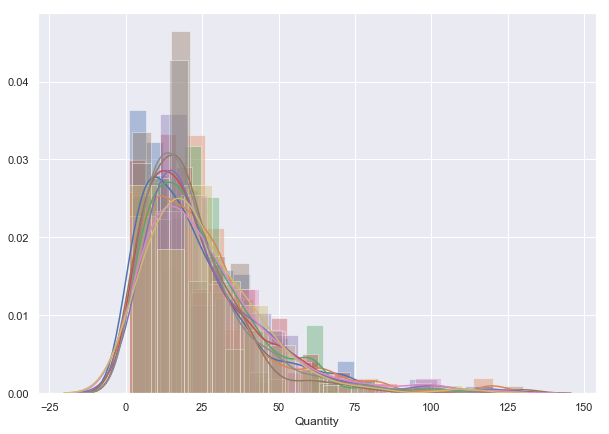

In [58]:
sns.distplot(empl_1['Quantity'], label = 'emp1')
sns.distplot(empl_2['Quantity'], label = 'emp2')
sns.distplot(empl_3['Quantity'], label = 'emp3')
sns.distplot(empl_4['Quantity'], label = 'emp4')
sns.distplot(empl_5['Quantity'], label = 'emp5')
sns.distplot(empl_6['Quantity'], label = 'emp6')
sns.distplot(empl_7['Quantity'], label = 'emp7')
sns.distplot(empl_8['Quantity'], label = 'emp8')
sns.distplot(empl_9['Quantity'], label = 'emp9')

In [59]:
print(stats.normaltest(empl_1.Quantity))
print(stats.normaltest(empl_2.Quantity))
print(stats.normaltest(empl_3.Quantity))
print(stats.normaltest(empl_4.Quantity))
print(stats.normaltest(empl_5.Quantity))
print(stats.normaltest(empl_6.Quantity))
print(stats.normaltest(empl_7.Quantity))
print(stats.normaltest(empl_8.Quantity))
print(stats.normaltest(empl_9.Quantity))

NormaltestResult(statistic=132.86674008677198, pvalue=1.407194003933747e-29)
NormaltestResult(statistic=106.79887681764708, pvalue=6.4404848402372496e-24)
NormaltestResult(statistic=98.38594839767316, pvalue=4.322776253133252e-22)
NormaltestResult(statistic=155.06321850560707, pvalue=2.1303449372777765e-34)
NormaltestResult(statistic=60.08853705036921, pvalue=8.952410062218527e-14)
NormaltestResult(statistic=114.94903007829242, pvalue=1.09429715073395e-25)
NormaltestResult(statistic=67.62002226670552, pvalue=2.0725200070387664e-15)
NormaltestResult(statistic=98.80753496906374, pvalue=3.501195779169355e-22)
NormaltestResult(statistic=43.76567579794708, pvalue=3.1362036223197405e-10)


<a id='log_transform_here'></a>

data is not gaussian but we can't resample since we need to keep associations between quantity and MonthsInJob so, lets see if we can use log transformation

In [60]:
empl_1['log'] = np.log(empl_1['Quantity'])
empl_2['log'] = np.log(empl_2['Quantity'])
empl_3['log'] = np.log(empl_3['Quantity'])
empl_4['log'] = np.log(empl_4['Quantity'])
empl_5['log'] = np.log(empl_5['Quantity'])
empl_6['log'] = np.log(empl_6['Quantity'])
empl_7['log'] = np.log(empl_7['Quantity'])
empl_8['log'] = np.log(empl_8['Quantity'])
empl_9['log'] = np.log(empl_9['Quantity'])

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


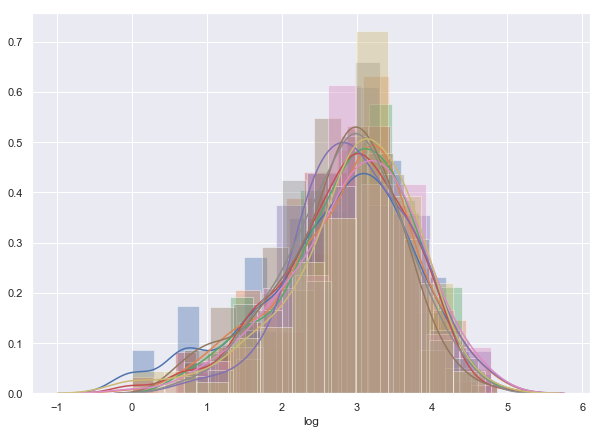

In [61]:
sns.distplot(empl_1['log'], label = 'emp1')
sns.distplot(empl_2['log'], label = 'emp2')
sns.distplot(empl_3['log'], label = 'emp3')
sns.distplot(empl_4['log'], label = 'emp4')
sns.distplot(empl_5['log'], label = 'emp5')
sns.distplot(empl_6['log'], label = 'emp6')
sns.distplot(empl_7['log'], label = 'emp7')
sns.distplot(empl_8['log'], label = 'emp8')
sns.distplot(empl_9['log'], label = 'emp9')

In [62]:
print(stats.normaltest(empl_1.log))
print(stats.normaltest(empl_2.log))
print(stats.normaltest(empl_3.log))
print(stats.normaltest(empl_4.log))
print(stats.normaltest(empl_5.log))
print(stats.normaltest(empl_6.log))
print(stats.normaltest(empl_7.log))
print(stats.normaltest(empl_8.log))
print(stats.normaltest(empl_9.log))

NormaltestResult(statistic=23.09544138812283, pvalue=9.658031644020506e-06)
NormaltestResult(statistic=9.573102675782499, pvalue=0.008341173726750983)
NormaltestResult(statistic=13.896732520879489, pvalue=0.000960202593914372)
NormaltestResult(statistic=27.19000664999532, pvalue=1.2467089421097758e-06)
NormaltestResult(statistic=1.1694799877826618, pvalue=0.5572507315721156)
NormaltestResult(statistic=8.18463802753808, pvalue=0.01670046002103526)
NormaltestResult(statistic=9.259612322961752, pvalue=0.009756650133673144)
NormaltestResult(statistic=3.8867991580130616, pvalue=0.14321624630982302)
NormaltestResult(statistic=20.663728398616882, pvalue=3.257829791806402e-05)


In [63]:
empl_1.head()

,Quantity,MonthsInJob,log
0,45.0,100.0,3.806662
1,36.0,100.0,3.583519
2,40.0,100.0,3.688879
3,50.0,119.0,3.912023
4,20.0,119.0,2.995732


In [64]:
empl_1['boxcox'] = stats.boxcox(empl_1['Quantity'], .5)
empl_2['boxcox'] = stats.boxcox(empl_2['Quantity'], .5)
empl_3['boxcox'] = stats.boxcox(empl_3['Quantity'], .5)
empl_4['boxcox'] = stats.boxcox(empl_4['Quantity'], .5)
empl_5['boxcox'] = stats.boxcox(empl_5['Quantity'], .5)
empl_6['boxcox'] = stats.boxcox(empl_6['Quantity'], .5)
empl_7['boxcox'] = stats.boxcox(empl_7['Quantity'], .5)
empl_8['boxcox'] = stats.boxcox(empl_8['Quantity'], .5)
empl_9['boxcox'] = stats.boxcox(empl_9['Quantity'], .5)

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0, 'Order Quantity')

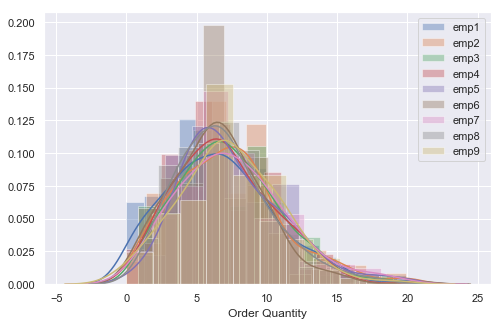

In [109]:

plt.figure(figsize = (8,5))
sns.distplot(empl_1['boxcox'], label = 'emp1')
sns.distplot(empl_2['boxcox'], label = 'emp2')
sns.distplot(empl_3['boxcox'], label = 'emp3')
sns.distplot(empl_4['boxcox'], label = 'emp4')
sns.distplot(empl_5['boxcox'], label = 'emp5')
sns.distplot(empl_6['boxcox'], label = 'emp6')
sns.distplot(empl_7['boxcox'], label = 'emp7')
sns.distplot(empl_8['boxcox'], label = 'emp8')
sns.distplot(empl_9['boxcox'], label = 'emp9')

plt.legend()
plt.xlabel('Order Quantity')


In [66]:
print(stats.normaltest(empl_1.boxcox))
print(stats.normaltest(empl_2.boxcox))
print(stats.normaltest(empl_3.boxcox))
print(stats.normaltest(empl_4.boxcox))
print(stats.normaltest(empl_5.boxcox))
print(stats.normaltest(empl_6.boxcox))
print(stats.normaltest(empl_7.boxcox))
print(stats.normaltest(empl_8.boxcox))
print(stats.normaltest(empl_9.boxcox))



NormaltestResult(statistic=16.33348047954139, pvalue=0.00028394209263362893)
NormaltestResult(statistic=20.35371577870838, pvalue=3.804054895664827e-05)
NormaltestResult(statistic=11.750129043094349, pvalue=0.002808612972624808)
NormaltestResult(statistic=17.4393151084693, pvalue=0.00016334311750423934)
NormaltestResult(statistic=17.68039375885265, pvalue=0.00014479423686999224)
NormaltestResult(statistic=20.485874544170688, pvalue=3.560810519207613e-05)
NormaltestResult(statistic=11.002330535871463, pvalue=0.0040820120282787494)
NormaltestResult(statistic=22.141583997192047, pvalue=1.5560234033776167e-05)
NormaltestResult(statistic=2.5653990721773643, pvalue=0.27728774091333613)


log transformation looks the best, will use that data for testing distributions

In [67]:
empl_1.head()

,Quantity,MonthsInJob,log,boxcox
0,45.0,100.0,3.806662,11.416408
1,36.0,100.0,3.583519,10.000000
2,40.0,100.0,3.688879,10.649111
3,50.0,119.0,3.912023,12.142136
4,20.0,119.0,2.995732,6.944272


In [68]:
empl_1['Employee'] = 1
empl_2['Employee'] = 2
empl_3['Employee'] = 3
empl_4['Employee'] = 4
empl_5['Employee'] = 5
empl_6['Employee'] = 6
empl_7['Employee'] = 7
empl_8['Employee'] = 8
empl_9['Employee'] = 9

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [69]:
empl_1.head()

,Quantity,MonthsInJob,log,boxcox,Employee
0,45.0,100.0,3.806662,11.416408,1
1,36.0,100.0,3.583519,10.000000,1
2,40.0,100.0,3.688879,10.649111,1
3,50.0,119.0,3.912023,12.142136,1
4,20.0,119.0,2.995732,6.944272,1


In [70]:
q3_transformed_data = pd.concat([empl_1, empl_2, empl_3, empl_4, empl_5, empl_6, empl_7, empl_8, empl_9])
q3_transformed_data.tail()

,Quantity,MonthsInJob,log,boxcox,Employee
1982,20.0,88.0,2.995732,6.944272,9
1983,6.0,88.0,1.791759,2.898979,9
1984,40.0,88.0,3.688879,10.649111,9
1985,10.0,88.0,2.302585,4.324555,9
1986,40.0,88.0,3.688879,10.649111,9


In [71]:
q3_transformed_data_v2 = copy.deepcopy(q3_transformed_data)

In [72]:
q3_transformed_data_v2.drop(columns = ['Quantity', 'boxcox'], inplace = True, axis = 1)
q3_transformed_data_v2.MonthsInJob = q3_transformed_data_v2.MonthsInJob.astype('int64')
q3_transformed_data_v2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2155 entries, 0 to 1986
Data columns (total 3 columns):
MonthsInJob    2155 non-null int64
log            2155 non-null float64
Employee       2155 non-null int64
dtypes: float64(1), int64(2)
memory usage: 67.3 KB


And now, we can run the ANOVA

In [73]:
formula = "log ~ C(Employee) + MonthsInJob"
           
lm = ols(formula, q3_transformed_data_v2).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)


                  sum_sq      df         F    PR(>F)
C(Employee)    13.569629     8.0  2.235877  0.022476
MonthsInJob     4.139111     1.0  5.456032  0.019593
Residual     1627.261833  2145.0       NaN       NaN


##### <font color='yellow'> Conclusion Question 3 </font>

The ANOVA P-values fail to reject the null that order quantities vary between employee and time-in-job

<a id='link_to_question_#4'></a>



## <font color ='lime'> Question 4 </font>
##### Do the distributions of product categories purchased change when a discount is offered?

In [74]:
cat_prod_OrDtl_orders_cust_df.head(1)

,CategoryId,CategoryName,Description,ProductId,ProductName,SupplierId,QuantityPerUnit,UnitPrice_x,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued,Id,OrderId,UnitPrice_y,Quantity,Discount,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,1.0,Beverages,"Soft drinks, coffees, teas, beers, and ales",1.0,Chai,1.0,10 boxes x 20 bags,18.0,39.0,0.0,10.0,0.0,10285/1,10285.0,14.4,45.0,0.2,QUICK,1.0,2012-08-20,2012-09-17,2012-08-26,2.0,76.83,QUICK-Stop,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,QUICK-Stop,Horst Kloss,Accounting Manager,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,0372-035188,None


In [75]:
q4df = copy.deepcopy(cat_prod_OrDtl_orders_cust_df[['CategoryName', 'Quantity', 'Region']])

In [76]:
q4df.head() 

,CategoryName,Quantity,Region
0,Beverages,45.0,Western Europe
1,Meat/Poultry,36.0,Western Europe
2,Seafood,40.0,Western Europe
3,Beverages,30.0,Western Europe
4,Beverages,40.0,Western Europe


In [77]:
q4df.CategoryName.value_counts()

Beverages         404
Dairy Products    366
Confections       334
Seafood           330
Condiments        216
Grains/Cereals    196
Meat/Poultry      173
Produce           136
Name: CategoryName, dtype: int64

In [78]:
q4df = copy.deepcopy(q4df[q4df['CategoryName']=='Dairy Products'])
print(q4df.head())
q4df.isna().sum()

      CategoryName  Quantity          Region
18  Dairy Products      35.0  Western Europe
34  Dairy Products      55.0  Western Europe
36  Dairy Products      49.0  Western Europe
37  Dairy Products      35.0  Western Europe
40  Dairy Products      25.0  Western Europe


CategoryName     0
Quantity         0
Region          16
dtype: int64

In [79]:
q4df.head()

,CategoryName,Quantity,Region
18,Dairy Products,35.0,Western Europe
34,Dairy Products,55.0,Western Europe
36,Dairy Products,49.0,Western Europe
37,Dairy Products,35.0,Western Europe
40,Dairy Products,25.0,Western Europe


In [80]:
q4df.dropna(inplace = True)
q4df.drop(['CategoryName'], axis = 1, inplace = True)
q4df.head()

,Quantity,Region
18,35.0,Western Europe
34,55.0,Western Europe
36,49.0,Western Europe
37,35.0,Western Europe
40,25.0,Western Europe


In [81]:
q4df.Region.value_counts()

Western Europe     132
North America       69
South America       49
British Isles       42
Northern Europe     17
Southern Europe     14
Scandinavia         13
Central America     12
Eastern Europe       2
Name: Region, dtype: int64

Eastern Europe, Central America, Scandinavia, Northern Europe and Southern Europe don't have enough observations on their own to run tests on.  I will combine Northern and Southern Europe and drop the others.

In [82]:
filter_list = ['Western Europe', 'North America', 'South America', 'British Isles', 'Northern Europe', 'Southern Europe'] # https://www.ritchieng.com/pandas-multi-criteria-filtering/
q4df = q4df[q4df.Region.isin(filter_list)]
q4df.Region.value_counts()

Western Europe     132
North America       69
South America       49
British Isles       42
Northern Europe     17
Southern Europe     14
Name: Region, dtype: int64

C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


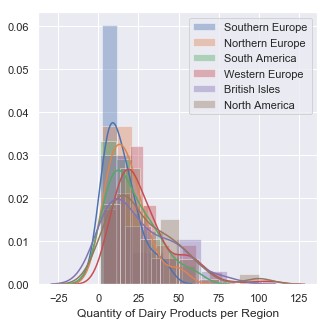

In [83]:
plt.figure(figsize = (5,5))
for rgn in set(q4df.Region):
    helper = q4df.loc[q4df.Region == rgn]
    sns.distplot(helper.Quantity, label = rgn)
    plt.legend()
    plt.xlabel('Quantity of Dairy Products per Region')





In [84]:
print(list(set(q4df['Region'])))

['Southern Europe', 'Northern Europe', 'South America', 'Western Europe', 'British Isles', 'North America']


In [85]:
for rgn in set(q4df['Region']):
    helper = q4df.loc[q4df.Region == rgn]
    print(stats.normaltest(helper.Quantity))

NormaltestResult(statistic=5.009894828792571, pvalue=0.08167989305885082)
NormaltestResult(statistic=6.711192667338976, pvalue=0.03488855872784588)
NormaltestResult(statistic=6.466900986101741, pvalue=0.039421241126965656)
NormaltestResult(statistic=43.16477868949511, pvalue=4.235331431739707e-10)
NormaltestResult(statistic=5.027457052708909, pvalue=0.0809657926595086)
NormaltestResult(statistic=19.28931394232651, pvalue=6.477071594603006e-05)


C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))
C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


In [86]:
# log transform quantities
q4df['Quantity'] = np.log(q4df['Quantity'])



C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


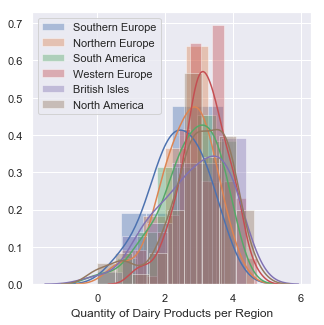

In [110]:
plt.figure(figsize = (5,5))
for rgn in set(q4df.Region):
    helper = q4df.loc[q4df.Region == rgn]
    sns.distplot(helper.Quantity, label = rgn)
    plt.legend()
    plt.xlabel('Quantity of Dairy Products per Region')

In [87]:
for rgn in set(q4df['Region']):
    helper = q4df.loc[q4df.Region == rgn]
    print(stats.normaltest(helper.Quantity))

NormaltestResult(statistic=0.5727087582525431, pvalue=0.7509964313253688)
NormaltestResult(statistic=3.2024892321984417, pvalue=0.20164539064896905)
NormaltestResult(statistic=6.7754457507725725, pvalue=0.03378552321855244)
NormaltestResult(statistic=5.143158081267064, pvalue=0.0764147880532662)
NormaltestResult(statistic=2.9747336375745665, pvalue=0.22596688459491002)
NormaltestResult(statistic=14.39570830320499, pvalue=0.0007481895884562356)


C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))
C:\Users\mngav\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


In [88]:
formula = "Quantity ~ C(Region)"
           
lm = ols(formula, q4df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

               sum_sq     df         F   PR(>F)
C(Region)   13.282293    5.0  3.557478  0.00382
Residual   236.711919  317.0       NaN      NaN


Looks like we can reject the null and accept the alternative that ther is a difference in order quantity of dairy products by region.<br>Now lets figure out what the differences look like.